In [40]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [41]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [42]:
y.shape, tx.shape

((10000,), (10000, 2))

# 1 Computing the Cost Function

**Warmup questions:**

1. The first column is only present because we use the "offset version" of the linear regression model. The second column represent all the height data points.
2. Each row represents one data point. 
3. Because of the offset: $w_0$.
4. **y** would be `(3, 1)` and **X** would be `(3, 2)`, with $X_{32}$ being the height of the third guy.

**Questions:**

Prove that MSE can be written in terms of the vector **e**:

Each **e** component represents the error for a given point. Then we only need to arrange **e** to square these values, which gives $\vec{e}^T\vec{e}$.



Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [43]:
def compute_loss(y, tx, w):
    e = y - tx.dot(w)
    
    # MSE
    #return (1.0 / (2 * len(y))) * e.T.dot(e)
    
    #MAE
    return (1.0 / len(y)) * np.sum(np.abs(e))

In [44]:
# Try with dummy w
w = np.array([1, 2])
print(compute_loss(y, tx, w))

72.2939220021


# 2 Grid Search

Fill in the function `grid_search()` below:

In [45]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    i = j = 0
    
    for i in range(len(w0)):
        for j in range(len(w1)):
            losses[i, j] = compute_loss(y, tx, np.array([w0[i], w1[j]]))
            
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=4.443009009145579, w0*=72.72727272727272, w1*=13.636363636363626, execution time=0.646 seconds


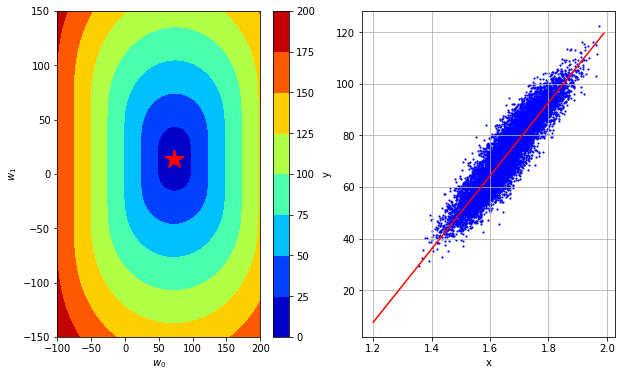

In [46]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=100)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

**Discussion**:
It turns out that the finer the grid, the better the estimation, since you can choose you parameters more finely, and find better matches. However, this implies computing the error with more values, then increasing the computation time. 

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [47]:
def compute_gradient(y, tx, w):
    """Compute the gradient for MSE."""
    e = y - tx.dot(w)
    return (-1.0 / len(y)) * tx.T.dot(e)

def compute_subgradient(y, tx, w):
    """Compute one of the subgradient for MAE."""
    e = y - tx.dot(w)
    s = np.sign(e).reshape(-1, 1)
    return np.sum(-tx * s, axis=0) / len(y) 

In [48]:
for w1 in [-100, -50, 0, 20, 60, 100]:
    print(compute_gradient(y, tx, np.array([75, w1])))

[   1.706078   -113.47971243]
[  1.706078   -63.47971243]
[  1.706078   -13.47971243]
[ 1.706078    6.52028757]
[  1.706078    46.52028757]
[  1.706078    86.52028757]


**Discussion**: here we fix $w_0$ to be 75, which seems to be around the true value from the last exercise. By varying w1, we see that the gradient does not change its first coordinate, and is pointing to the center of the figure, varying on the y axis.

Please fill in the functions `gradient_descent` below:

In [49]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        gradient = compute_subgradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        
        # Update parameter vector
        w = w - (gamma * gradient)
                
        # Store w and loss
        ws.append(w)
        losses.append(loss)
        
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [50]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 10

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=73.29392200210518, w0=10.0, w1=-2.218536465647958e-14
Gradient Descent(1/49): loss=63.29392200210518, w0=20.0, w1=-4.437072931295916e-14
Gradient Descent(2/49): loss=53.29392200210517, w0=30.0, w1=-6.655609396943874e-14
Gradient Descent(3/49): loss=43.29404723059966, w0=39.998000000000005, w1=0.006292368147182035
Gradient Descent(4/49): loss=33.31059435419375, w0=49.95, w1=0.12192821504262985
Gradient Descent(5/49): loss=23.67345510465397, w0=59.096000000000004, w1=1.639861420838721
Gradient Descent(6/49): loss=15.777631207768643, w0=65.928, w1=5.8244807519957575
Gradient Descent(7/49): loss=9.731932942882485, w0=70.744, w1=11.028133377808057
Gradient Descent(8/49): loss=5.3324155522965055, w0=73.742, w1=14.594252508862589
Gradient Descent(9/49): loss=4.531000557309278, w0=72.96000000000001, w1=13.03167099868458
Gradient Descent(10/49): loss=4.4517423077518155, w0=73.352, w1=13.920628796547744
Gradient Descent(11/49): loss=4.437060098599115, w0=73.172, w1=1

In [51]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure>

**Discussion**:

* **Learning rate**: a very small learning rate implies a very slow convergence, and does not lead to optimal results if the number of steps is low. However, too large rates imply that the procedure does not converge at all and oscillates around the optimal point. The trick is to find a **large enough** learning rate in order to converge as fast as possible.
* **Initial parameters**: independently of the initial parameters value, the procedure will eventually converge if there are enough steps. However, the further from the true value they are, the slower the convergence.

# 4 Stochastic gradient descent

In [52]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    return compute_gradient(y, tx, w)


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    w = initial_w
    ws = [initial_w]
    losses = []
    
    for step in range(max_iters):
        # Get one random mini batch
        for batch_y, batch_tx in batch_iter(y, tx, batch_size):
            loss = compute_loss(batch_y, batch_tx, w)
            gradient = compute_stoch_gradient(batch_y, batch_tx, w)
            
            # Update gradient
            w = w - (gamma * gradient)
            
            # Store values
            ws.append(w)
            losses.append(loss)
        
    return losses, ws

In [53]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.059 seconds


In [54]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure>

# 5 Effect of Outliers and MAE Cost Function, and Subgradient Descent

### Exercise 5

Load data containing outliers:

In [55]:
sub_height, sub_weight, sub_gender = load_data(sub_sample=True, add_outlier=True)
sub_x, sub_mean_x, sub_std_x = standardize(sub_height)
sub_y, sub_tx = build_model_data(sub_x, sub_weight)

Plot it:

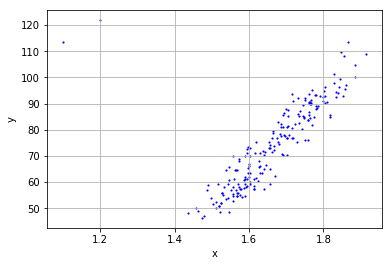

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(sub_height, sub_weight, marker=".", color='b', s=5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid()

Learn parameters with gradient descent: 

In [57]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
sub_gradient_losses, sub_gradient_ws = gradient_descent(sub_y, sub_tx, w_initial, max_iters, gamma)

def plot_sample_figure(n_iter):
    fig = gradient_descent_visualization(
        sub_gradient_losses, sub_gradient_ws, grid_losses, grid_w0, grid_w1, sub_mean_x, sub_std_x, 
        sub_height, sub_weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_sample_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

Gradient Descent(0/49): loss=74.06780585492638, w0=0.1, w1=8.727891896558162e-17
Gradient Descent(1/49): loss=73.96780585492638, w0=0.2, w1=1.7455783793116323e-16
Gradient Descent(2/49): loss=73.86780585492637, w0=0.30000000000000004, w1=2.6183675689674487e-16
Gradient Descent(3/49): loss=73.76780585492638, w0=0.4, w1=3.4911567586232647e-16
Gradient Descent(4/49): loss=73.66780585492639, w0=0.5, w1=4.3639459482790806e-16
Gradient Descent(5/49): loss=73.56780585492638, w0=0.6, w1=5.236735137934897e-16
Gradient Descent(6/49): loss=73.46780585492637, w0=0.7, w1=6.109524327590712e-16
Gradient Descent(7/49): loss=73.36780585492637, w0=0.7999999999999999, w1=6.982313517246528e-16
Gradient Descent(8/49): loss=73.26780585492638, w0=0.8999999999999999, w1=7.855102706902344e-16
Gradient Descent(9/49): loss=73.16780585492637, w0=0.9999999999999999, w1=8.72789189655816e-16
Gradient Descent(10/49): loss=73.06780585492639, w0=1.0999999999999999, w1=9.600681086213977e-16
Gradient Descent(11/49): loss

A Jupyter Widget

<function __main__.plot_sample_figure>

### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)